# UX 9 Analysis of Variance (ANOVA)

author:
- |
    Sofia Dahl, sof@create.aau.dk\
    Dept. Architecture, Design and Media Technology, Aalborg University Copenhagen
---

## Learning goals

After working your way through this notebook you should be able to..
- Explain why one ANOVA is preferred to multiple t-tests
- Perform and interpret a one-way ANOVA using available functions
- Structure data in long and wide format required
- 
## Table of Contents

- [1. Multiple comparisons](#MulitipleComp)
    - [1.1. ANOVA](#ANOVA)
    - [1.2. Assumptions for using ANOVA](#ANOVAassump)
- [2. Independent one-way ANOVA](#IndepANOVA)
   - [2.1 Defining model and performing ANOVA](#Definemodel)
- [3. Pairwise Contrasts and Reporting Results](#contrasts)
- [4. Setting up data](#Settingup)


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import pingouin as pg

Matplotlib is building the font cache; this may take a moment.


<a id= 'MulitipleComp'> </a>

## 1. Multiple comparisons
We frequently have more than two conditions we want to compare. For instance we might want to investigate players'  scores with different settings in a factorial design. This could mean we want to compare obtained scores with 2 settings x 3 levels of players expertise (measured by some standard).

Technically, we can compare for effects with pairwise comparisons using t-tests but it is a bad idea. The probability of  making a type I error is 5\%  ($\alpha$ =.05) for *each* test. The more comparisons we make, the higher the risk of finding a significant difference purely by chance

If three experimental groups have sample means from the same distributions, that is if $\mu_1$ = $\mu_2$ =$\mu_3$, we need to make three pairwise comparisons (1 versus 2, 2 versus 3, and 1 versus 3). The probability  of NO  Type I error is $(0.95)^3=0.86$ ($\alpha$ =.05). That is, the probability of making *at least* one Type I error when doing these three comparisons is $1-0.86=0.14$, or 14\%. Much higher! 

Typically one of two solutions to this problem is used. If multiple t-tests are used, the $\alpha$-level can be adjusted so that each test is more strictly performed. Typically such a *Bonferroni* correction is used to compensate for the increased probability of Type I errors when doing multiple t-tests. But a better approach is to do ONE test,  an *omnibus test*, that looks for an overall effect, and drop all the pairwise comparisons being the source of the increased Type I error risk. This is what ANOVA does.

### Try out 1:

How large probability of making at least one Type 1 error is there for pairwise testing with five experimental groups?

<a id= 'ANOVA'> </a>

### 1.1. ANOVA

A commonly used omnibus test is Analysis of Variance (ANOVA), which includes all categories and factors at once. A very commonly used test is Analysis of Variance (ANOVA). There are many different kinds of ANOVAs, those that are intended for repeated measurements and multiple factors (for instance, there might be several levels of auditory and visual feedback in the example above, or perhaps you would like to include the age and handedness as a factor that might influence player performance). The general principle, however, is to compare the variance between different groups (i.e. conditions or  treatments) with the variance occurring within each group.

$$F  =\frac {variance -between - treatments} {variance - within-  treatments} =\frac {variance_{explained}} {variance_{unexplained}} $$

Hopefully the talk of variance now rings a bell, because again the sum of squares are at the basis of these calculations. In the Inferental chapter we calculated the effect size from the ratio between the model $ SS_M$ and the total $SS_T$ sum of squares. The F statistic is essentially ratio between the explained variance of the model $SS_{M}$ and the residual variance $SS_{Res}$:
$$\frac {SS_{M}} {SS_{Res}}$$


The model in the case of ANOVA is a bit more complex in that we typically have more means than two to do the sum of squares for (one for each treatment /group). Because we calculate this for the full model at once, the test itself cannot say if ALL or just ONE of the groups differ significantly. For this we need to make follow-up comparisons that *contrasts* the different groups (just as you would in t-tests). These contrast tests can be *planned* already at the start of the experiment, or *post-hoc*, after the ANOVA has been run. In both cases, precautions againt multiple tests have to be taken, for instance by dividing the significance level by the number of tests done as (Bonferroni correction). 

So when reporting results from an ANOVA, we would both report the results from the overall test on the full model, but also the results of the follow-up pairwise comparisons. Some software reports these contrasts, perhaps even using different tests. Which ones to report depend a bit. 


### Try out 2:
Consider that you have data from 4 groups like in the code below and that an ANOVA shows a significant effect. How many pairwise comparisons should you plan to detect *which* differences between the groups that causes the overall effect?

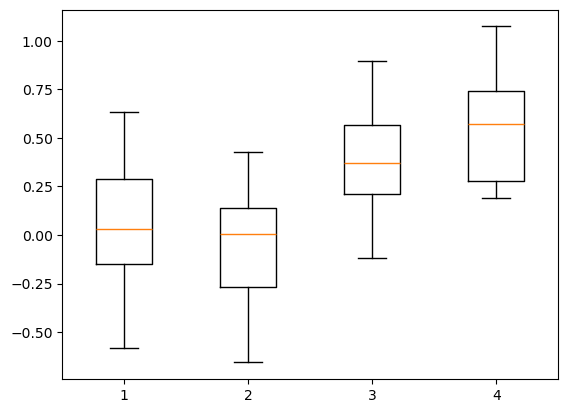

In [2]:
#We generate four randomly drawn samples from  normally distributions 

K=40 #variable for sample size
score1=np.random.normal(0.025,0.25,K)
score2=np.random.normal(0.01,0.25,K)
score3=np.random.normal(0.3,0.25,K)
score4=np.random.normal(0.56,0.25,K)

plt.boxplot([score1,score2, score3,score4])
plt.show()


<a id= 'ANOVAassump'> </a>

### 1.3 Assumptions for using ANOVA
Similar to t-tests, there are some conditions that should be met, if the analysis should show the correct result. Most importantly, the samples must be *representative of the population*.

Furthermore data must fulfill the following assumptions for parametric data. 
That is
- Variance should be approximately equal for each group (homogeneity of variance)
-  Sampling distributions should be normal for each group (normality)

In ANOVA and multiple regression, it is  more the *residuals* (the unexplained variance) that must fulfill these criteria, and some statistic software report the diagnostics for this with the model statistics.  

Similar to t-test, we also need to know whether the data points are *related* or *unrelated*. That is, if you have different groups of participants, each testing one condition (e.g. type of controller), the data points are clearly independent observations. For normal ANOVA the samples must be *independent* , that is the scores do not affect each other. 

If you choose a within-group design, with the same participants in all the groups, several observations will be from the same person and are therefore dependent. You *DO NOT* get the correct result if you attempt to do a normal ANOVA on dependent values. For dependent repeated measures an Repeated Measures ANOVA must be used and in this case, there is an additional assumption of *sphericity*, or that variances of tifferences between condition levels are equal.

<a id= 'IndepANOVA'> </a>

## 2. Independent one-way ANOVA


When comparing two different groups, as in a between groups design, the
samples from the two groups should be independent.

Let us take the example of a digital instrument played using different controllers. One group played using standard mouse and keyboard ("Mouse"), while two other groups tested other controllers ("Control1" and "Control2"). Is there a difference in the dependent variable (e.g. their score or rating) depending on the controller used?

We can set up the null and alternative hypothesis

- H0: There is no significant difference in scores between the different controllers. 
- H1: There is a significant difference in scores between the different controllers.

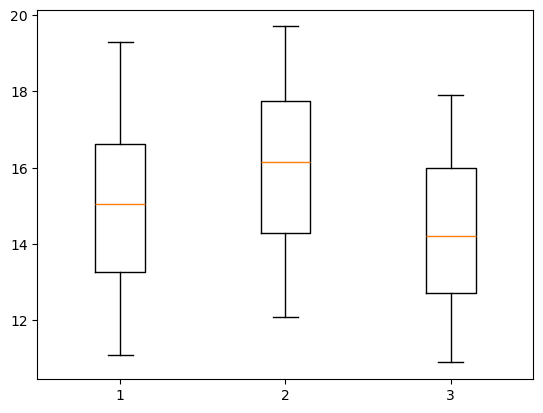

In [10]:
# Data for different controllers
df= pd.DataFrame([[ 13.5, 14.6, 12.7],
    [14.6, 15.6, 13.4],
    [ 12.7, 13.6, 12.1],
    [ 15.5, 16.7, 15.0],
    [ 11.1, 12.1, 10.9],
    [ 16.4, 17.6, 15.7],
    [ 13.2, 14.2, 12.8],
    [ 19.3, 19.5, 17.9],
    [ 16.7, 17.8, 16.1],
    [ 18.4, 19.7, 17.9]], columns=(["Mouse","Control1","Control2"]), index=[1,2,3,4,5,6,7,8,9,10])

# We first look at the data 
plt.boxplot([df.Mouse,df.Control1,df.Control2])
plt.show()

We start by testing the assumptions for ANOVA. The box plot looks promising with respect to equal variance, but we should do the Levene variance test nonetheless. We also use Shapiro-Wilks test to check for normality.

In [11]:
# The Levene variance test tests the null hypothesis that 
# all samples come from populations with equal variances
stats.levene(df.Mouse,df.Control1,df.Control2)

LeveneResult(statistic=0.005508899933893261, pvalue=0.9945073637505352)

In [12]:
#To test the null hypothesis that the data was drawn from a normal distribution
#we start with Shapiro-Wilks test: 
stats.shapiro(df.Mouse), stats.shapiro(df.Control1), stats.shapiro(df.Control2) 

(ShapiroResult(statistic=0.9758614502079733, pvalue=0.9392499148746949),
 ShapiroResult(statistic=0.9599998483116511, pvalue=0.7858707323505119),
 ShapiroResult(statistic=0.936767066219863, pvalue=0.5176317548751614))

None of the above tests indicate that we should reject the null hypothesis as they 
show p-values > 0.05. Which is good for since we want to use a parametric test (ANOVA). It seems promising to proceed to the actual test.


<a id= 'Definemodel'> </a>

### 2.1 Defining model and performing ANOVA

We are now ready to define the model we want to test as our dependent variable "Score" and the independent "Controller". 

For the one-way independent ANOVA we can enter the dependent and independent variable in the function and get the F-statistic and probability out:

In [13]:
F, p = stats.f_oneway(df.Mouse,df.Control1,df.Control2)
print('F statistic = {:5.3f} and probability p = {:5.3f}'.format(F, p)) 

F statistic = 1.128 and probability p = 0.339


Based on this result, we retain the null hypothesis, because the probability of obtaining our results by random is not below our criterion ($\alpha <0.05$) 

To report the result of an ANOVA we will need the F-statistic, probability and also the degrees of freedom. Unlike the t-test, we now have several means that are estimated and recuding our degrees of freedom, and we report two kinds: One for the effect of the model ($df_M$) and  one for the residuals of the model ($df_R$). 


$df_M$, calculated as the number of factors/groups k - 1 
$df_R$, calculated as the number of observations N -k

In our example, we have 3 controllers,  which leads to $df_M=3-1=2$
and a total of 30 observations (10 for each controller), which yields $df_R=30-3=27$.


### Try out 1: 
Add a fourth group by copying the data of Controller 1 and modifying by reducing 3.5 overall. Would you say from the box plot, that it is likely to be an overall difference between groups now?

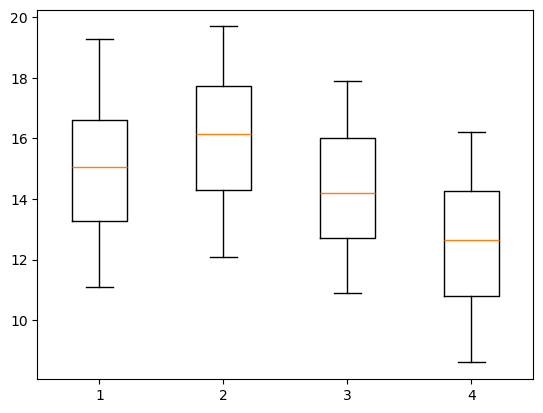

In [14]:
#adding fourth controller
data['Controller3']=data.Control1-3.5

# plot the data 
plt.boxplot([data.Mouse,data.Control1,data.Control2,data.Controller3])
plt.show()

### Try out 2: 
Redo the one-way anova analysis with the new controller. Would you still retain the null hypothesis?

In [ ]:
#F, p = stats.f_oneway(data.Mouse,data.Control1,data.Control2,data.Controller3)


Even if the anova shows a *main effect* we do not know WHICH of the controllers that actually cause the difference in scores. A bit further on we will look do some paired comparisons, but first let's discuss something else that also is important. 

### 2.2. Effect size One-way Independent ANOVA

Like in for t-tests or correlation, it is good practice to investigate and report the effect size. 

It is possible to calculate $r^2$ (and then r) from the sum of squares 

$$r^2 =\frac {SS_{M}} {SS_{T}}$$

Where $SS_{M}$ is the sum of squares for the model and $SS_{T}$ is the total sum of squares.

But as explained in Fields & Hole, there are more accurate measures of effect size. For instance $\omega$ based on the mean squared like this

$$\omega^2 =\frac {MS_{M}-MS_{R}} {MS_{M}+((n-1)\times MS_{R})}$$

where $MS_{M}$ is the mean squares of the model, $MS_{R}$ is the mean residual squares, and n is the number of participants/observations in a group.

Both Sum of squares and Mean squares are reported by a lot of statistical software (e.g. SPSS, R). Another common measure of effects size also typically reported in statistics is *eta squared* $\eta^2$ or *partial eta squared*.

These measures are not readily available from the f_oneway output so we would have to calculate them separately. But now that you have the basis of what an ANOVA is, let's use the Pinguin package to do the analysis.

## 3. Pairwise Contrasts and Reporting Results

As mentioned above, our task is not done with the ANOVA output table. Any main effect should be investigated to sort out *which* of the groups that contributed toward it. In order to answer this qustion, one perform tests to find out which differences that contributed to the main effect. 
Here we will not go into details about what tests that are best to use where. For pairwise *post-hoc tests* (that is, the contrasts were not planned before doing the ANOVA) the more commonly used ones are Bonferroni and Tukey HSD test.

Now is a good time to introduce Pinguin package because then we get more functionality to check assumptions and calculate diffrent kinds of analysis. You find information on how to install Pinguin and what it can do https://pingouin-stats.org/build/html/index.html# For simplicity, we will use their example data:

In [25]:
#Note that you may have to install pinguin before importing
#pip install pingouin

import pingouin as pg

# Load an example dataset comparing pain threshold as a function of hair color
df = pg.read_dataset('anova')
df


,Subject,Hair color,Pain threshold
0,1,Light Blond,62
1,2,Light Blond,60
2,3,Light Blond,71
3,4,Light Blond,55
4,5,Light Blond,48
5,6,Dark Blond,63
6,7,Dark Blond,57
7,8,Dark Blond,52
8,9,Dark Blond,41
9,10,Dark Blond,43


First we need to check assumptions such as equality of variances:

In [23]:
# We first test the assumption of equality of variances
pg.homoscedasticity(data=df, dv='Pain threshold', group='Hair color')


,W,pval,equal_var
levene,0.392743,0.760016,True


Note how different this output is, and that it provides the output of what the p-value means in terms of the null hypothesis.

Since Levene's test suggest variances are equal between groups, we proceed with the ANOVA:

In [24]:
#a regular one-way ANOVA
pg.anova(data=df, dv='Pain threshold', between='Hair color')

,Source,ddof1,ddof2,F,p-unc,np2
0,Hair color,3,15,6.791407,0.004114,0.575962


Again, we get more output that we need in order to understand and interpret the data. 
- Source is the independent variable
- ddof1 are the degrees of freedom for the independent variable (that is, levels of hair color)
- ddof2 are the degrees of freedom for the dependent variable (the data points of pain threshold)
- F is the value of the F statistic
- p-unc is the uncorrected p-value telling us the probability of obtaining the F statistic given the H0
- np2 is the effect size as partial eta-squared

You can also get Sum of squares and other values out (see help(pg.anova))

So from this output we have the F-statistic and its probability, and the effect size. Now we can perform a post-hoc Tukey test, to see which of the different hair colors that contribute to the main effect.

In [27]:
# Perform post-hoc Tukey test
pg.pairwise_tukey(data=df, dv='Pain threshold', between='Hair color')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,Dark Blond,Dark Brunette,51.2,37.4,13.8,5.168623,2.669957,0.074068,1.413596
1,Dark Blond,Light Blond,51.2,59.2,-8.0,5.168623,-1.547801,0.435577,-0.810661
2,Dark Blond,Light Brunette,51.2,42.5,8.7,5.482153,1.586968,0.414728,0.982361
3,Dark Brunette,Light Blond,37.4,59.2,-21.8,5.168623,-4.217758,0.003708,-2.336811
4,Dark Brunette,Light Brunette,37.4,42.5,-5.1,5.482153,-0.930291,0.789321,-0.626769
5,Light Blond,Light Brunette,59.2,42.5,16.7,5.482153,3.046249,0.036647,2.015280


Since the data set has four different levels of hair color, there are six pairwise comparisons to find out which of these that are contributing to the main effect. Looking at the reported probability for each comparison (p-tukey), only the compairson Dark Brunette and Light Blond have p<0.05, so the ANOVA main effect in pain threshold is mainly due to the difference between very dark and very light hair color. We can see what the means are, but it would be good to also check the variability for these.

In [41]:
#group dataframe according to hair color
grouped = df.groupby(["Hair color"])
grouped.describe()

Subject                                                  \
                 count  mean       std   min    25%   50%    75%   max   
Hair color                                                               
Dark Blond         5.0   8.0  1.581139   6.0   7.00   8.0   9.00  10.0   
Dark Brunette      5.0  17.0  1.581139  15.0  16.00  17.0  18.00  19.0   
Light Blond        5.0   3.0  1.581139   1.0   2.00   3.0   4.00   5.0   
Light Brunette     4.0  12.5  1.290994  11.0  11.75  12.5  13.25  14.0   

               Pain threshold                                                
                        count  mean       std   min   25%   50%   75%   max  
Hair color                                                                   
Dark Blond                5.0  51.2  9.284396  41.0  43.0  52.0  57.0  63.0  
Dark Brunette             5.0  37.4  8.324662  30.0  32.0  35.0  39.0  51.0  
Light Blond               5.0  59.2  8.526429  48.0  55.0  60.0  62.0  71.0  
Light Brunette            4.0  42.5  5.446712  37.0  40.0  41.5  44.0  50.0

  
We are now ready to report the result of the analysis:

"A one-way independent ANOVA showed a main effect of hair color on participants' pain threshold, F(3,15)=6.79, p=0.004, $\eta^2$=0.56). 
Post-hoc comparisons using the Tukey HSD test indicated that the mean pain threshold for Dark Brunette (M = 37.4, SD = 1.58) was significantly different compared to that of Light Blond (M = 59.2, SD = 1.58). "


<a id= 'Settingup'> </a>

## 4. Setting up data
Before we proceed to look at ANOVA for values that are dependent we need to adress different kinds of dataformats. As you start using different kinds of analysis and use different packages, you may need to set up data in a different way so that the functions can read and interpret the data properly. 

In some cases we have *wide format* where the dependent variable for each condition is collected in columns for each participant:

|Participant|DVCase1 |DVCase2|DVCase3|
|-----|-----|--------|-----|
|1   |71   |72      |70  |
|2   |61   |73      |71  |
|:  |:     | .       |  .  | 

And in other cases we use *long format*, where the dependent variable is displayed in one columns over several rows:

|Participant|Condition |DVScore|
|-----|-----|--------|
|1   |Case1  |71|
|1   |Case2  |72 |
|1   |Case2  |70 |
|2   |Case1  |61|
|2   |Case2  |73 |
|2   |Case2  |71 |
|:  |:     | .   |  


Many softwares/function will expect data to be in one or the other format. Specifically for repeated measures analysis, *pivot table*, that contains means or other summaries of the data  are often required.
https://en.wikipedia.org/wiki/Pivot_table

Switching bewteen these data table formats can be a pain. A great tip is to consider the software and functions you will use already before actual data collection. In this way you can save data in the proper way already from the beginning (and save lots of time).

In order to practise the switch between table formats we return to the data frame "data" we used earlier, containing different scores using different input devices. To simplify the transition, we will add a variable "id" to denote each participant.

In [42]:
#We add a variable "id" to denote each participant
data["id"] = data.index

data

,Mouse,Control1,Control2,Controller3,id
1,13.5,14.6,12.7,11.1,1
2,14.6,15.6,13.4,12.1,2
3,12.7,13.6,12.1,10.1,3
4,15.5,16.7,15.0,13.2,4
5,11.1,12.1,10.9,8.6,5
6,16.4,17.6,15.7,14.1,6
7,13.2,14.2,12.8,10.7,7
8,19.3,19.5,17.9,16.0,8
9,16.7,17.8,16.1,14.3,9
10,18.4,19.7,17.9,16.2,10


In order to change from this "wide" format to "long" format we can use the pandas function "melt". Afterwards, there should be 10 rows for each input device (10 participants for each case).

In [44]:
#we go to "long" format using the pandas function "melt"

longdata=data.melt(id_vars=['id'], value_vars=['Mouse', 'Control1', 'Control2'], var_name='Controller', value_name='Score')
#longdata #Check data, instead of 10 rows, you should now have 10 rows for each case

We now have the *long* format and, because we only have one factor this conversion was not too complicated. But often there might be many independent and dependent variables in one data frame, as well as other factors (e.g. particpants' age, how trained musicians they are etc) and in these cases the conversion between long and wide format can quickly become cumbersome.


### Try out 3: 
What type of data format (long or wide) is the Hair color and pain threshold data (Section 3) in?